An example of image panoptic segmentation using DETR, not completed.  
https://github.com/facebookresearch/detr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow-addons
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install git+https://github.com/facebookresearch/detectron2.git

In [1]:
import os
import io
import requests
import warnings
import torch
import torchvision
import panopticapi
import numpy as np
import tensorflow as tf
from copy import deepcopy
from PIL import Image
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
os.chdir('./drive/My Drive/Python/Research')
warnings.filterwarnings('ignore')
from modules import detr

In [ ]:
class Processor:
  def __init__(self, small, pth, postprocessor, catelog, threshold=0.85):
    self.detr = detr.DETR(small)
    self.detr.loading(pth)
    self.postprocessor = postprocessor
    self.meta = MetadataCatalog.get(catelog)
    self.trans = torchvision.transforms.Compose([
      torchvision.transforms.Resize(800),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  
  def single_predicting(self, image):
    image1 = self.trans(image).unsqueeze(0)
    pred1 = list(self.detr.propagating(np.transpose(image1.numpy(), [0, 2, 3, 1])))
    pred1 = dict(zip(['pred_logits', 'pred_boxes', 'pred_masks'], [torch.Tensor(i1.numpy()) for i1 in pred1]))
    result1 = self.postprocessor(pred1, torch.as_tensor(image1.shape[-2:]).unsqueeze(0))[0]
    info1 = deepcopy(result1['segments_info'])
    seg1 = Image.open(io.BytesIO(result1['png_string']))
    seg1, shape1 = torch.from_numpy(panopticapi.utils.rgb2id(np.array(seg1, dtype=np.uint8))), seg1.size

    for i1 in range(len(info1)):
      c1 = info1[i1]['category_id']

      if info1[i1]['isthing']:
        info1[i1]['category_id'] = self.meta.thing_dataset_id_to_contiguous_id[c1]
      else:
        info1[i1]['category_id'] = self.meta.stuff_dataset_id_to_contiguous_id[c1]

    v1 = Visualizer(np.array(image.copy().resize(shape1))[:, :, ::-1], self.meta, scale=1.0)
    return v1.draw_panoptic_seg_predictions(seg1, info1, area_threshold=0).get_image()

  def batch_predicting(self, image):
    return None


image_model = Processor(
  False,
  'models/detr_r101/detr-r101-panoptic-40021d53.pth',
  torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', return_postprocessor=True)[1],
  'coco_2017_val_panoptic_separated')

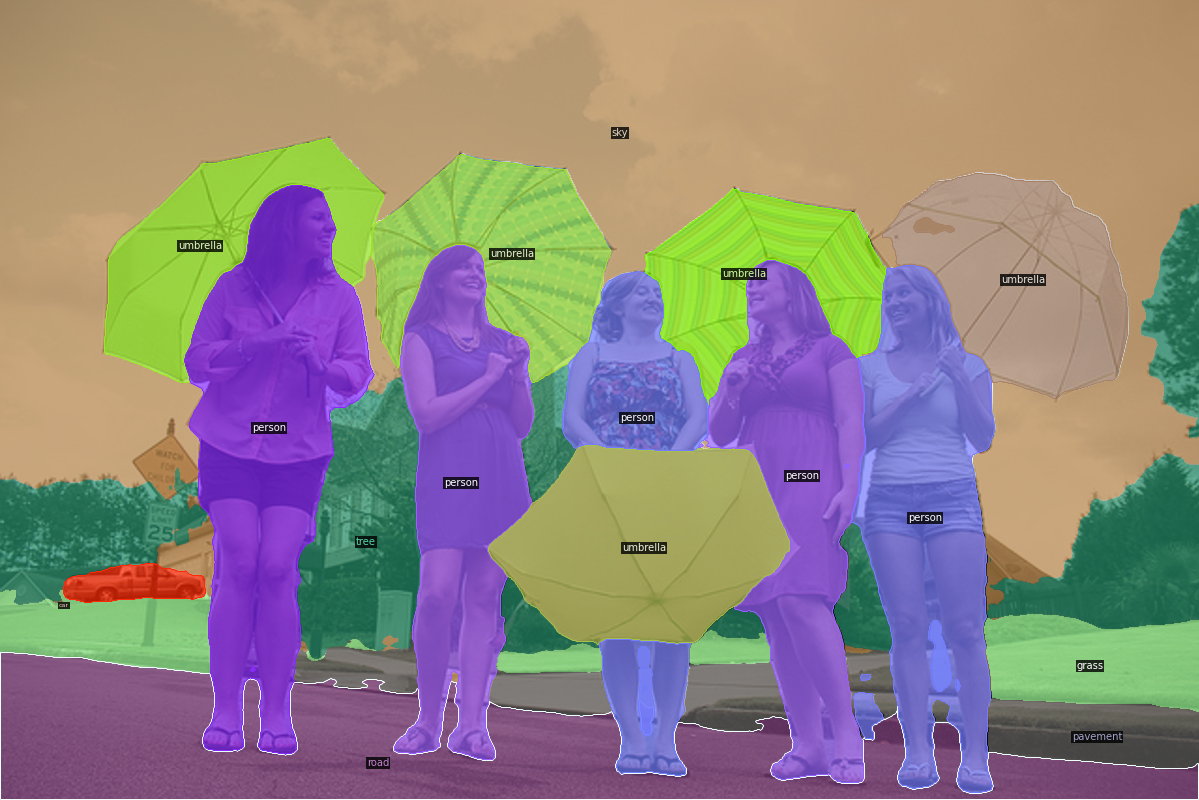

In [3]:
image_url = requests.get('http://images.cocodataset.org/val2017/000000281759.jpg', stream=True).raw
image_origin = Image.open(image_url)
cv2_imshow(image_model.single_predicting(image_origin))